# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:



**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income



In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

Examining portfolio table

**portfolio.json**

It contains 10 rows and 6 columns.
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO (buy one get one free), discount, informational (no monetary reward)
* difficulty (int) - minimum required spend to complete an offer, in dollars
* reward (int) - reward given for completing an offer, in dollars
* duration (int) - time for offer to be open, in days
* channels (list of strings) - how the offer is communicated (email, mobile, social, web)




In [2]:
portfolio.shape

(10, 6)

In [9]:
portfolio.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


All id's are unique

In [4]:
portfolio.groupby(['id']).size()
portfolio.id.nunique()


10

There are 4 bogo types of offer, 4 discounts and 2 infomational.

In [10]:
portfolio.groupby(['offer_type']).size()

offer_type
bogo             4
discount         4
informational    2
dtype: int64

Below is the breakdown when reward size is included

In [11]:
portfolio.groupby(['offer_type','reward']).size()

offer_type     reward
bogo           5         2
               10        2
discount       2         2
               3         1
               5         1
informational  0         2
dtype: int64

Below is the breakdown when difficulty is added

In [6]:
portfolio.groupby(['offer_type','reward','difficulty']).size()

offer_type     reward  difficulty
bogo           5       5             2
               10      10            2
discount       2       10            2
               3       7             1
               5       20            1
informational  0       0             2
dtype: int64

Below is the breakdown when duration is added

In [7]:
portfolio.groupby(['offer_type','reward','difficulty','duration']).size()

offer_type     reward  difficulty  duration
bogo           5       5           5           1
                                   7           1
               10      10          5           1
                                   7           1
discount       2       10          7           1
                                   10          1
               3       7           7           1
               5       20          10          1
informational  0       0           3           1
                                   4           1
dtype: int64

That is a simple to read breakdown of the 10 offer types. Each have a distinct id.

The channel type is a nested column. So I can expand this field out if I want to try to determine the influence each media channel has within an offer. Although I will need to add a tag to the id field or have a have a way of tracking this for later analysis

**profile.json**

It contains 17000 rows and 5 columns
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

 Although 2175 rows have age with value set to 118 which represents a missing value. The gender and income fields are also missing values on the rows where age is 118. I suspect these will not be useful during the analysis and will need to be filtered out.

In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [16]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


All ids are unique

In [41]:
profile.id.nunique() == len(profile)

True

I can see there is some missing data for gender and income. Also there seems to be lots of ages=118. 

There is the exact same number of gender and income nulls. Which leads me to think (and hope) they are directly related

In [23]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

There is also the 2175 values where age is 118. This leads me to believe that 118 is a filler value for a null age value.

In [30]:
len(profile.loc[profile['age'] == 118])

2175

I will confirm that the nulls in gender and income and the 118 value for age all occur for the same values. And as shown below all null values do indeed occur when age is 118.

In [31]:
(profile.loc[profile['age'] == 118]).isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

The only information left in the rows with the nulls is the id and the date they became a member. I will filter these values out for now. Perhaps later I can imput this data by comparing to the transcript table and seeing if the id's appear there.

The highest age remaining is 101 which is a more believable maximum age.

In [38]:
profile.loc[profile['age'] != 118].age.max()

101

A minimum age of 18 is also believable.

In [39]:
profile.loc[profile['age'] != 118].age.min()

18

Creating a histogram of age to check it looks reasonable

<AxesSubplot:>

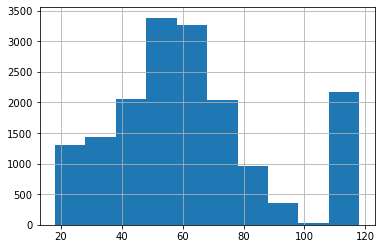

In [47]:
profile.age.hist()

max and min incomes are within a reasonable range also

In [43]:
profile.income.max()

120000.0

In [45]:
profile.income.min()

30000.0

Creating a histogram of income to check it looks reasonable

<AxesSubplot:>

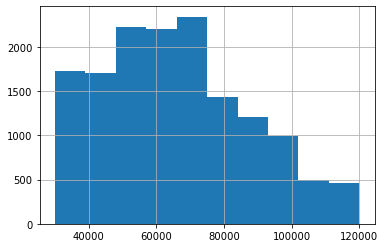

In [48]:
profile.income.hist()

There is plenty more men than female in this study. But that is not an issue. There are a few non male nor female genders too.

In [46]:
profile.groupby(['gender']).size()

gender
F    6129
M    8484
O     212
dtype: int64

Became member on

In [148]:
profile.became_member_on.max()

20180726

In [149]:
profile.became_member_on.min()

20130729

Examining the dates that users became a member to make sure they seem to fall in a reasonable time range

Converting each value that a user became a member to a 6 figure int holding the year and month they joined.

In [46]:
dates=profile.became_member_on.astype(str)

months=[]

for date in dates:
    month = date[:6] 
    month=int(month)
    months.append(month)


In [47]:
from collections import Counter

Counter(sorted(months))

Counter({201307: 5,
         201308: 68,
         201309: 57,
         201310: 56,
         201311: 48,
         201312: 52,
         201401: 64,
         201402: 57,
         201403: 56,
         201404: 64,
         201405: 66,
         201406: 60,
         201407: 56,
         201408: 58,
         201409: 56,
         201410: 49,
         201411: 55,
         201412: 50,
         201501: 64,
         201502: 63,
         201503: 61,
         201504: 58,
         201505: 68,
         201506: 56,
         201507: 69,
         201508: 293,
         201509: 295,
         201510: 271,
         201511: 259,
         201512: 273,
         201601: 294,
         201602: 288,
         201603: 308,
         201604: 310,
         201605: 298,
         201606: 289,
         201607: 319,
         201608: 305,
         201609: 271,
         201610: 292,
         201611: 271,
         201612: 281,
         201701: 294,
         201702: 277,
         201703: 286,
         201704: 298,
         20170

The Spread of the joiners seem reasonable to me with no suspicious outliers

<AxesSubplot:>

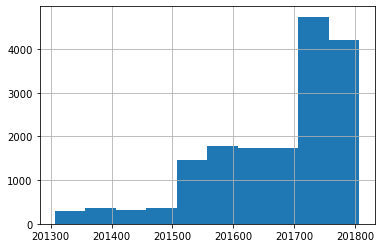

In [122]:
pd.Series(months).hist()

**transcript.json**

It contains 306534 rows and 4 columns.
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test.
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [11]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


There are no null values.

In [153]:
transcript.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


Inspecting the person column in transcript. I can see the average person has multiple occurances in the dataset.

In [87]:
(transcript.groupby('person').count())

,event,value,time
person,,,
0009655768c64bdeb2e877511632db8f,20,20,20
00116118485d4dfda04fdbaba9a87b5c,7,7,7
0011e0d4e6b944f998e987f904e8c1e5,18,18,18
0020c2b971eb4e9188eac86d93036a77,19,19,19
0020ccbbb6d84e358d3414a3ff76cffd,23,23,23
...,...,...,...
fff3ba4757bd42088c044ca26d73817a,23,23,23
fff7576017104bcc8677a8d63322b5e1,18,18,18
fff8957ea8b240a6b5e634b6ee8eafcf,10,10,10


The average person occurs over 18 times

In [88]:
(transcript.groupby('person').count()).mean()

event    18.031412
value    18.031412
time     18.031412
dtype: float64

This is the same length of the profile table. So I suspect all ids in the profile table occur in transcript. I will confirm laters

In [84]:
len(transcript.groupby('person').count())

17000

Spot checking one value. I can see it has multiple different events.

In [75]:

transcript.loc[transcript['person']=='00116118485d4dfda04fdbaba9a87b5c']


,person,event,value,time
56475,00116118485d4dfda04fdbaba9a87b5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},168
85769,00116118485d4dfda04fdbaba9a87b5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},216
104088,00116118485d4dfda04fdbaba9a87b5c,transaction,{'amount': 0.7000000000000001},294
187632,00116118485d4dfda04fdbaba9a87b5c,transaction,{'amount': 0.2},456
193680,00116118485d4dfda04fdbaba9a87b5c,transaction,{'amount': 3.19},474
248359,00116118485d4dfda04fdbaba9a87b5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},576
284472,00116118485d4dfda04fdbaba9a87b5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},630


Although this is one of the values I intend to filter out. But perhaps I could use random forest algorithm to estimate the missing data

In [77]:
profile.loc[profile['id']=='00116118485d4dfda04fdbaba9a87b5c']

,gender,age,id,became_member_on,income
4434,None,118,00116118485d4dfda04fdbaba9a87b5c,20180425,NaN


The below example does have good data in the profile table and will be used during training/test. They have plenty of solid data explaining offers they recieved or viewed or completed. And of the transactions they made.

In [79]:

transcript.loc[transcript['person']=='0009655768c64bdeb2e877511632db8f']

,person,event,value,time
55972,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
77705,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192
89291,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 22.16},228
113605,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336
139992,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372
153401,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},408
168412,0009655768c64bdeb2e877511632db8f,transaction,{'amount': 8.57},414
168413,0009655768c64bdeb2e877511632db8f,offer completed,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,414
187554,0009655768c64bdeb2e877511632db8f,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},456
204340,0009655768c64bdeb2e877511632db8f,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},504


In [80]:
profile.loc[profile['id']=='0009655768c64bdeb2e877511632db8f']

,gender,age,id,became_member_on,income
3793,M,33,0009655768c64bdeb2e877511632db8f,20170421,72000.0


The time column isnt as uniform as I expected. But I dont see it as an obvious issue. 

In [63]:
transcript.groupby('time').count().sort_values(by=['value'])

,person,event,value
time,,,
150,894,894,894
162,910,910,910
156,914,914,914
330,938,938,938
318,940,940,940
...,...,...,...
168,16150,16150,16150
336,16302,16302,16302
504,16822,16822,16822


The histogram shows lots of variation without any obvious trend. It is possibly explained by a drop in customers at the weekend. The dips in the data are not too far from 7 days apart. e.g. 156 hours (914 incidences) 330 hours (938 incidences) are  7.25 days apart. This is just one possible explanation for why the data is like this. It is also possible that its just an anomoly of how the data is collected. Perhaps the data wasn't being collected consitently. But either way, I dont see it as an issue.

<AxesSubplot:>

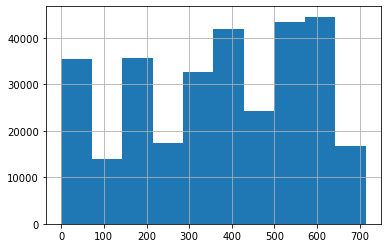

In [43]:
transcript.time.hist()

Less than 11% of the rows are classified as “offer completed”. This may affect how I prepare the data or how I evaluate the model.

In [50]:
transcript.groupby(['event']).agg('count')

,person,value,time
event,,,
offer completed,33579,33579,33579
offer received,76277,76277,76277
offer viewed,57725,57725,57725
transaction,138953,138953,138953


<AxesSubplot:>

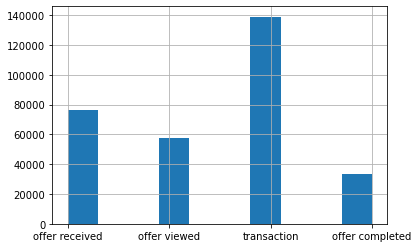

In [55]:
transcript.event.hist()